<a href="https://colab.research.google.com/github/seinJOO/PythonClass/blob/main/Python_Basic/0608/57_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### 캐글
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

### 캐글 라이브러리 설치
!pip list | findstr kaggle

/bin/bash: findstr: command not found
ERROR: Pipe to stdout was broken
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='UTF-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [2]:
### kaggle.json 파일 업로드
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys() :
  print('Upload user file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

## API 키 파일인 kaggle.json을 저장할 위치를 생성하여 처리
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
Upload user file "kaggle.json" with length 70 bytes


In [83]:
### API를 이용한 캐글 데이터 다운로드
!kaggle competitions download -c house-prices-advanced-regression-techniques

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [84]:
!unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [94]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Data loading is done!')

Data loading is done!


In [95]:
print('train_data 크기 (shape)', train.shape)
print('test_data 크기 (shape)', test.shape)

# 데이터 크기가 같지 않음 (컬럼 개수 상이) -> 필요한 데이터만 뽑아서 쓰자! 
# train에는 sales price가 있으나 test에는 없음

train_data 크기 (shape) (1460, 81)
test_data 크기 (shape) (1459, 80)


In [88]:
### 머신러닝 workflow
# 1. 데이터 불러오기
# 2. 전처리
# 3. 최적화
# 4. 적용

# 1단계 : 데이터를 합쳐 사용하고, SalePrice는 Y값으로 별도 저장
# 2단계 : 데이터 전처리 - 중복값, ID, 결측치 제거, 문자 데이터는 Encoding작업을 통해 숫자로 변환

In [ ]:
# 피쳐 엔지니어링 => 이상치 제거, 종속변수 변환, 결측치 채우기

In [96]:
# 이상치 제거 -> 이상치는 수치형 데이터에서 자주 나타남. 특히 값의 범위가 크면 정확도가 떨어지기 때문에 확인이 필요함
# 이상치는 단순히 수치화 된 값으로 처리할 수 없음. 특히 주관적인 편향성이 드러나는 경우가 있을 수 있기 때문

# 집의 옵션/퀄리티가 좋지 않음에도 불구하고 비싼 값으로 팔린 경우의 데이터 삭제
train.drop(train[(train['OverallQual'] < 4) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['OverallCond'] < 4) & (train['SalePrice']>200000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

print(train.shape)  # 행 두 개가 삭제됨

(1458, 81)


The value of mu before log transformation is : 180761.24142661178
The value of sigma before log transformation is : 79270.93617295024


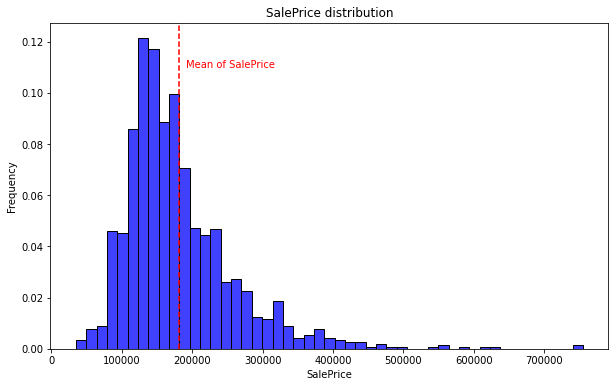

In [97]:
# 시각화 : Seaborn에 있는 histplot()
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

(mu, sigma) = norm.fit(train['SalePrice'])
print('The value of mu before log transformation is :', mu)
print('The value of sigma before log transformation is :', sigma)

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(train['SalePrice'], color="b", stat="probability")
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')

plt.axvline(mu, color='r', linestyle='--')
plt.text(mu+10000, 0.11, 'Mean of SalePrice', rotation=0, color='r')
fig.show()

The value of mu before log transformation is : 12.0233397799989
The value of sigma before log transformation is : 0.3989191793099824


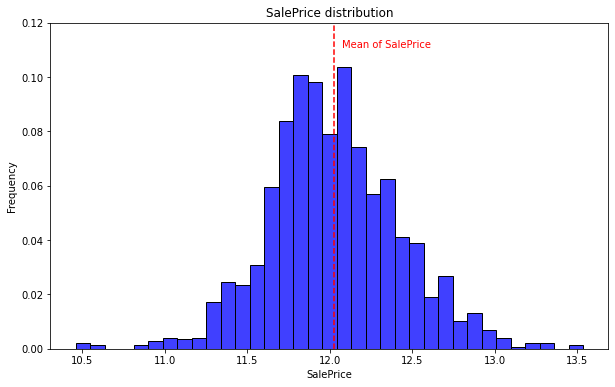

In [98]:
## 종속변수 : SalePrice를 활용하여 정규분포화
# 시각화 : Seaborn에 있는 histplot()
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

train['SalePrice'] = np.log1p(train['SalePrice'])    # salePrice를 기준으로 정규분포화

(mu, sigma) = norm.fit(train['SalePrice'])
print('The value of mu before log transformation is :', mu)
print('The value of sigma before log transformation is :', sigma)

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(train['SalePrice'], color="b", stat="probability")
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')

plt.axvline(mu, color='r', linestyle='--')
plt.text(mu+0.05, 0.111, 'Mean of SalePrice', rotation=0, color='r')
plt.ylim(0,0.12)
fig.show()

In [99]:
### 데이터 합치기
# 훈련 데이터와 테스트 데이터를 합치기 전, 입력변수로 사용할  ID는 별도 객체로 저장한 후 삭제

# 별도로 저장
train_id = train['Id']
test_id = test['Id']

# ID 제거
train.drop(['Id'], axis = 1, inplace=True)
test.drop(['Id'], axis = 1, inplace=True)

train.shape, test.shape   # id컬럼이 하나씩 삭제됨을 확인 가능

((1458, 80), (1459, 79))

In [100]:
## Sale Price 변수도 별도로 추출
y = train['SalePrice'].reset_index(drop=True)
train = train.drop('SalePrice', axis = 1)
train.shape, test.shape, y.shape

((1458, 79), (1459, 79), (1458,))

In [101]:
## train과 test를 합치기 <= 이상치를 제외시킴
all_df = pd.concat([train, test]).reset_index(drop = True)
all_df.shape

(2917, 79)

In [102]:
## 결측치 처리 : 중간에 데이터 값이 비어있는 경우
# 결측치를 확인해 비율로 계산한 뒤 내림차순으로 정렬하는 함수
def check_na(data, head_num = 6) :
  isnull_na = (data.isnull().sum() / len(data)) * 100
  data_na = isnull_na.drop(isnull_na[isnull_na == 0].index).sort_values(ascending=False)
  missing_data = pd.DataFrame({'Missing Ratio' : data_na,
                               'Data Type' : data.dtypes[data_na.index]})
  print('결측치 데이터 컬럼과 건수 :', missing_data)

check_na(all_df, 20)

결측치 데이터 컬럼과 건수 :               Missing Ratio Data Type
PoolQC            99.657182    object
MiscFeature       96.400411    object
Alley             93.212204    object
Fence             80.425094    object
FireplaceQu       48.680151    object
LotFrontage       16.626671   float64
GarageFinish       5.450806    object
GarageQual         5.450806    object
GarageCond         5.450806    object
GarageYrBlt        5.450806   float64
GarageType         5.382242    object
BsmtExposure       2.811107    object
BsmtCond           2.811107    object
BsmtQual           2.776826    object
BsmtFinType2       2.742544    object
BsmtFinType1       2.708262    object
MasVnrType         0.788481    object
MasVnrArea         0.754200   float64
MSZoning           0.137127    object
BsmtFullBath       0.068564   float64
BsmtHalfBath       0.068564   float64
Functional         0.068564    object
Utilities          0.068564    object
GarageArea         0.034282   float64
GarageCars         0.034282   flo

In [103]:
# 가장 비율이 높은 6개 삭제 (결측치 5%대까지만 허용)
all_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], axis = 1, inplace = True)
check_na(all_df, 20)

결측치 데이터 컬럼과 건수 :               Missing Ratio Data Type
GarageCond         5.450806    object
GarageQual         5.450806    object
GarageYrBlt        5.450806   float64
GarageFinish       5.450806    object
GarageType         5.382242    object
BsmtCond           2.811107    object
BsmtExposure       2.811107    object
BsmtQual           2.776826    object
BsmtFinType2       2.742544    object
BsmtFinType1       2.708262    object
MasVnrType         0.788481    object
MasVnrArea         0.754200   float64
MSZoning           0.137127    object
Functional         0.068564    object
Utilities          0.068564    object
BsmtFullBath       0.068564   float64
BsmtHalfBath       0.068564   float64
GarageArea         0.034282   float64
GarageCars         0.034282   float64
TotalBsmtSF        0.034282   float64
KitchenQual        0.034282    object
Electrical         0.034282    object
BsmtUnfSF          0.034282   float64
BsmtFinSF2         0.034282   float64
BsmtFinSF1         0.034282   flo

In [105]:
all_df.shape

(2917, 73)

In [ ]:
## 결측치를 채우는 함수 : fillna
# 결측치 채우는 방식
# 1. 각각의 변수를 확인하여 개별적으로 필요한 데이터를 채워넣는 방식
#    문자 데이터는 빈도수 위주로 채워넣고, 수치 데이터는 평균 또는 중간값을 이용
# 2. 한꺼번에 0 또는 None 값으로 채우는 방법

# 이 분석에서는 문자열 데이터의 빈도수 중 가장 높은 값으로 문자열 값을 처리, 수치 데이터는 Median으로 채움

In [106]:
### 결측치 데이터 처리 - 문자열 데이터
# Object에 해당하는 변수명만 별도로 추출
import numpy as np
cat_all_vars = train.select_dtypes(exclude=[np.number])
print('The whole number of all_vars', len(list(cat_all_vars)))

final_cat_vars = []
for v in cat_all_vars :
  if v not in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'] :
    final_cat_vars.append(v)
print('The whole number of final_cat_vars', len(final_cat_vars))  # 결측치가 높아서 제외한 컬럼 삭제

for i in final_cat_vars :
  all_df[i] = all_df[i].fillna(all_df[i].mode()[0])   
  # mode() : 빈도수 계산하는 함수 - 빈도수가 높은 순서대로 리스트가 만들어짐 
  # fillna() : 결측치를 인자값으로 채움

check_na(all_df, 20)


The whole number of all_vars 43
The whole number of final_cat_vars 38
결측치 데이터 컬럼과 건수 :               Missing Ratio Data Type
GarageYrBlt        5.450806   float64
MasVnrArea         0.754200   float64
BsmtFullBath       0.068564   float64
BsmtHalfBath       0.068564   float64
BsmtFinSF1         0.034282   float64
BsmtFinSF2         0.034282   float64
BsmtUnfSF          0.034282   float64
TotalBsmtSF        0.034282   float64
GarageCars         0.034282   float64
GarageArea         0.034282   float64


In [107]:
### 결측치 데이터 처리 - 수치형 데이터

import numpy as np
num_all_vars = list(train.select_dtypes(include=[np.number]))
print('The whole number of all_vars', len(list(num_all_vars)))

num_all_vars.remove('LotFrontage')
print('The whole number of num_all_vars', len(num_all_vars))  # 결측치가 높아서 제외한 컬럼 삭제

for i in num_all_vars :
  all_df[i].fillna(all_df[i].median(), inplace=True)   
  # mode() : 빈도수 계산하는 함수 - 빈도수가 높은 순서대로 리스트가 만들어짐 
  # fillna() : 결측치를 인자값으로 채움

check_na(all_df, 20)

The whole number of all_vars 36
The whole number of num_all_vars 35
결측치 데이터 컬럼과 건수 : Empty DataFrame
Columns: [Missing Ratio, Data Type]
Index: []


In [108]:
### 왜도(Skewness) 값 처리
# 왜도는 크게 분포의 비대칭도를 나타내는 통계량을 의미함
# 정규분포와 같이 대칭인 분포는 왜도가 0이다 => 자료의 대칭성을 알아보는 하나의 척도
# 수치형 데이터에 적용하게 되고, 예측 변수를 활용할 때에 왜도를 보정하는 것이 중요하다

# 수치형 데이터의 왜도를 전부 구해서 내림차순 정렬
from scipy.stats import skew

def find_skew(x) :
  return skew(x)

skew_features = all_df[num_all_vars].apply(find_skew).sort_values(ascending=False)
skew_features

MiscVal          21.939672
PoolArea         16.892477
LotArea          12.867139
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.318923
BsmtFinSF2        4.144503
EnclosedPorch     4.013741
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.615714
OpenPorchSF       2.534326
WoodDeckSF        1.841876
1stFlrSF          1.469798
BsmtFinSF1        1.429239
MSSubClass        1.374726
GrLivArea         1.271773
TotalBsmtSF       1.165468
BsmtUnfSF         0.919795
2ndFlrSF          0.860643
TotRmsAbvGrd      0.760404
Fireplaces        0.734449
HalfBath          0.695072
BsmtFullBath      0.626733
OverallCond       0.584601
BedroomAbvGr      0.329555
GarageArea        0.241611
OverallQual       0.196514
MoSold            0.195229
FullBath          0.164226
YrSold            0.132129
GarageCars       -0.218309
GarageYrBlt      -0.398311
YearRemodAdd     -0.451063
YearBuilt        -0.600023
dtype: float64

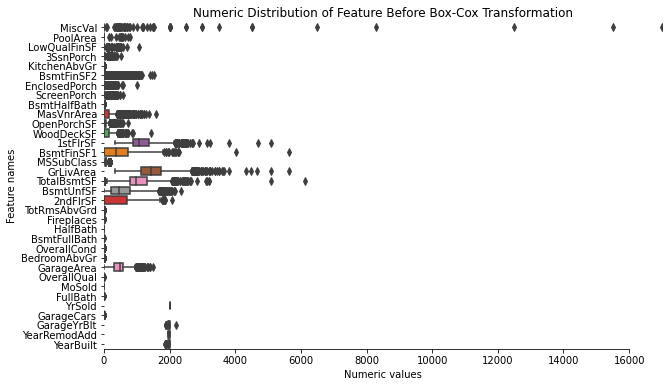

In [109]:
## 위 값을 기준으로 시각화 처리
# all_df[num_all_vars].head()

skewnewss_index=list(skew_features.index)
skewnewss_index.remove('LotArea')   # 다른 변수들에 비해 값의 크기가 매우 크기 때문에 변수들의 비대칭 분포도 확인이 어려워서 제외함
all_numeric_df = all_df.loc[:, skewnewss_index]
all_numeric_df

fig, ax = plt.subplots(figsize = (10,6))
ax.set_xlim(0, all_numeric_df.max().sort_values(ascending=False)[0])
ax = sns.boxplot(data=all_numeric_df[skewnewss_index], orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel='Feature names')
ax.set(xlabel='Numeric values')
ax.set(title='Numeric Distribution of Feature Before Box-Cox Transformation')
sns.despine(trim=True, left=True)

In [110]:
# Box-Cox Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

high_skew = skew_features[skew_features > 1]
high_skew_index = high_skew.index
print('The data before Box-Cox Transformation : \n', all_df[high_skew_index].head())

for num_var in high_skew_index :
  all_df[num_var] = boxcox1p(all_df[num_var], boxcox_normmax(all_df[num_var] + 1))

print('The data after Box-Cox Transformation: \n', all_df[high_skew_index].head())

The data before Box-Cox Transformation : 
    MiscVal  PoolArea  LotArea  LowQualFinSF  3SsnPorch  KitchenAbvGr  \
0        0         0     8450             0          0             1   
1        0         0     9600             0          0             1   
2        0         0    11250             0          0             1   
3        0         0     9550             0          0             1   
4        0         0    14260             0          0             1   

   BsmtFinSF2  EnclosedPorch  ScreenPorch  BsmtHalfBath  MasVnrArea  \
0         0.0              0            0           0.0       196.0   
1         0.0              0            0           1.0         0.0   
2         0.0              0            0           0.0       162.0   
3         0.0            272            0           0.0         0.0   
4         0.0              0            0           0.0       350.0   

   OpenPorchSF  WoodDeckSF  1stFlrSF  BsmtFinSF1  MSSubClass  GrLivArea  \
0           61        

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [112]:
## 도출변수 생성
# 도출변수 : 주어진 변수 내에서 새로운 변수를 도출하는 과정
# 여러개의 컬럼(변수)을 재그룹화하여 변수의 개수를 줄일 수 있음
# 변수를 줄인다는 관점에서 차원 축소와 비슷하지만 조금 다른 개념
# 차원 축소(PCA)라는 기법을 수치형 데이터에 약간의 통계적이고도 기계적으로 적용 -> 자료 본연의 특성을 읽음
# 도출 변수는 기존 변수들의 특징을 고려해서 새로운 변수를 만들어 내는 것 - 연구자의 주관적인 분석이 들어감

all_df['TotalSF'] = all_df['TotalBsmtSF'] + all_df['1stFlrSF'] + all_df['2ndFlrSF']
all_df = all_df.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1)

print(all_df.shape)

(2917, 71)


In [113]:
## 합쳐서 생성되는 값들을 묶어서 하나로 도출변수를 생성

all_df['Total_Bathrooms'] = (all_df['FullBath'] + (0.5 * all_df['HalfBath']) + all_df['BsmtFullBath'] + (0.5*all_df['BsmtHalfBath']))
all_df['Total_porch_sf'] = (all_df['OpenPorchSF'] + (0.5 * all_df['3SsnPorch']) + all_df['EnclosedPorch'] + (0.5*all_df['ScreenPorch']))
all_df = all_df.drop(['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch'], axis=1)

print(all_df.shape)

(2917, 65)


In [114]:
# 연도와 관련된 데이터 총 4개를 연도 관련 변수를 추출
num_all_vars = list(train.select_dtypes(include=[np.number]))
year_feature = []
for var in num_all_vars:
  if 'Yr' in var:
    year_feature.append(var)
  elif 'Year' in var:
    year_feature.append(var)
  else:
    print(var,"is not related with Year")

print(year_feature)

MSSubClass is not related with Year
LotFrontage is not related with Year
LotArea is not related with Year
OverallQual is not related with Year
OverallCond is not related with Year
MasVnrArea is not related with Year
BsmtFinSF1 is not related with Year
BsmtFinSF2 is not related with Year
BsmtUnfSF is not related with Year
TotalBsmtSF is not related with Year
1stFlrSF is not related with Year
2ndFlrSF is not related with Year
LowQualFinSF is not related with Year
GrLivArea is not related with Year
BsmtFullBath is not related with Year
BsmtHalfBath is not related with Year
FullBath is not related with Year
HalfBath is not related with Year
BedroomAbvGr is not related with Year
KitchenAbvGr is not related with Year
TotRmsAbvGrd is not related with Year
Fireplaces is not related with Year
GarageCars is not related with Year
GarageArea is not related with Year
WoodDeckSF is not related with Year
OpenPorchSF is not related with Year
EnclosedPorch is not related with Year
3SsnPorch is not rela

In [115]:
for i, var in enumerate(year_feature) :
  if var != 'YrSold' : print(var)

YearBuilt
YearRemodAdd
GarageYrBlt


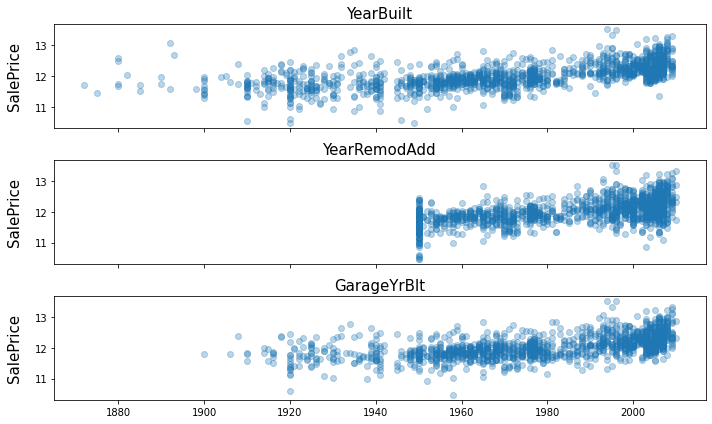

In [116]:
# SalePrice와 연관지어 시각화
fig, ax = plt.subplots(3,1,figsize=(10,6), sharex=True, sharey=True)

for i, var in enumerate(year_feature):
  if var != 'YrSold':
    ax[i].scatter(train[var],y,alpha=0.3)
    ax[i].set_title('{}'.format(var),size=15)
    ax[i].set_ylabel('SalePrice',size=15, labelpad=12.5)

plt.tight_layout()
plt.show()

In [117]:
all_df = all_df.drop(['YearBuilt', 'GarageYrBlt'], axis=1)
print(all_df.shape)

(2917, 63)


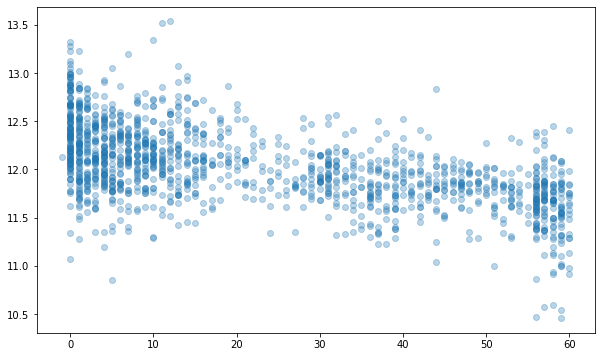

In [118]:
## 도출변수, YrSold와 YearRemodelAdd 연도 차이 값에 대한 변수 -> YearsSinceRemodel
YearsSinceRemodel = train['YrSold'].astype(int) - train['YearRemodAdd'].astype(int)

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(YearsSinceRemodel, y, alpha=0.3)
fig.show()

# 리모델링 여부 데이터를 빼니까 하향곡선을 이룸 -> 리모델링 여부가 집값 상승에 중요한 역할을 한다고 판단 가능!

In [119]:
### 전체 데이터 대비 차이값을 저장하는 코드( 집이 팔린 연도 - 리모델링한 연도 ) 작성 후 YrSold와 YearRemodAdd
all_df['YearsSinceRemodel'] = all_df['YrSold'].astype(int) - all_df['YearRemodAdd'].astype(int)
all_df = all_df.drop(['YrSold','YearRemodAdd'], axis=1)

print(all_df.shape)
print(all_df.head())

(2917, 62)
   MSSubClass MSZoning    LotArea Street LotShape LandContour Utilities  \
0    6.505897       RL  13.454344   Pave      Reg         Lvl    AllPub   
1    4.252612       RL  13.725427   Pave      Reg         Lvl    AllPub   
2    6.505897       RL  14.066408   Pave      IR1         Lvl    AllPub   
3    6.869385       RL  13.714276   Pave      IR1         Lvl    AllPub   
4    6.505897       RL  14.584552   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope Neighborhood  ... WoodDeckSF PoolArea MiscVal MoSold  \
0    Inside       Gtl      CollgCr  ...   0.000000      0.0     0.0      2   
1       FR2       Gtl      Veenker  ...  56.354941      0.0     0.0      5   
2    Inside       Gtl      CollgCr  ...   0.000000      0.0     0.0      9   
3    Corner       Gtl      Crawfor  ...   0.000000      0.0     0.0      2   
4       FR2       Gtl      NoRidge  ...  42.362009      0.0     0.0     12   

   SaleType  SaleCondition      TotalSF Total_Bathrooms Total_porch_s

In [120]:
### 더미 변수의 응용 : 더미 변환(범주형 -> 수치형)
print(all_df['PoolArea'])
all_df['PoolArea'].value_counts()

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2912    0.0
2913    0.0
2914    0.0
2915    0.0
2916    0.0
Name: PoolArea, Length: 2917, dtype: float64


0.000000    2904
5.843016       1
6.048366       1
5.945809       1
5.913421       1
5.786591       1
5.854879       1
6.161330       1
4.721829       1
5.553561       1
5.718338       1
5.130821       1
5.922801       1
6.231252       1
Name: PoolArea, dtype: int64

In [121]:
## Data Binding : 재그룹화 -> 0은 0으로, 0이 아닌 값은 1로 처리
def count_dummy(x) :
  if x > 0 : return 1
  else : return 0 

all_df['PoolArea'] = all_df['PoolArea'].apply(count_dummy)
print(all_df['PoolArea'].value_counts())
all_df['GarageArea'] = all_df['GarageArea'].apply(count_dummy)
print(all_df['GarageArea'].value_counts())
all_df['Fireplaces'] = all_df['Fireplaces'].apply(count_dummy)
print(all_df['Fireplaces'].value_counts())

0    2904
1      13
Name: PoolArea, dtype: int64
1    2760
0     157
Name: GarageArea, dtype: int64
1    1497
0    1420
Name: Fireplaces, dtype: int64


In [122]:
## 값이 3개 이상인 경우, Label Encoding, Ordinal Encoding, One-Hot Encoding
# label encoding : 문자열 데이터를 각 범주의 개수에 따라서 숫자로 변환
# one-hot encoding : 값을 변수로 변환 - 1과 0으로 변환

# label encoding ( = y축 값을 변경 )
from sklearn.preprocessing import LabelEncoder
import pandas as pd

temp = pd.DataFrame({'Food_Name' : ['Apple', 'Chicken', 'Broccoli'], 'Calories' : [95, 231, 50]})

encoder = LabelEncoder()
encoder.fit(temp['Food_Name'])
labels = encoder.transform(temp['Food_Name'])
print(list(temp['Food_Name']), "==>", labels)

# One-Hot Encoding ( = x축 값을 변경 )
import pandas as pd

temp = pd.DataFrame({'Food_Name' : ['Apple', 'Chicken', 'Broccoli'], 'Calories' : [95, 231, 50]})
temp = pd.get_dummies(temp)   # 데이터프레임에서 더미값을 받는 방법
print(temp)
print(temp.shape)

['Apple', 'Chicken', 'Broccoli'] ==> [0 2 1]
   Calories  Food_Name_Apple  Food_Name_Broccoli  Food_Name_Chicken
0        95                1                   0                  0
1       231                0                   0                  1
2        50                0                   1                  0
(3, 4)


In [123]:
### 범주형 변수 -> 명목척도, 서열척도
# 서열척도 : ordinalencoder()
# 데이터의 순서와 서열이 다르다면 서열의 순서를 변화해서 고정시킬 필요가 있음
# 사용하면 순서에 따라 중요도가 달라질 수 있음
import pandas as pd

temp = pd.DataFrame({'Food_Name' : ['Apple', 'Chicken', 'Broccoli'], 'Calories' : [95, 231, 50]})
temp['Food_No'] = temp.Food_Name.replace(to_replace=['Chicken', 'Broccoli', 'Apple'], value=[1,2,3])
print(temp[['Food_Name', 'Food_No']])


  Food_Name  Food_No
0     Apple        3
1   Chicken        1
2  Broccoli        2


In [53]:
# 명목 척도 : 값의 순서나 서열에 의해 영향을 받지 않는 값들로 되어 있음
#             범주형 데이터 개수가 많다면 불필요하다고 생각되는 부분을 'other'로 재그룹화하여 처리 가능

# OrdinalEncoding과 One-Hot Encoding은 머신러닝 알고리즘 선택에 영향을 줌
# One-Hot Encoding은 의사결정계열의 머신러닝보다는 선형회귀, 로지스틱 회귀, SVM같은 Non-Tree 기반 알고리즘에 유리
# OrdinalEncoding은 의사결정나무, 랜덤포레스트와 같은 Tree기반 알고리즘에 더 유리
# 다만, 필요에 따라 다양하게 적용하여 모형을 학습한 후 결과를 통해서 결정 가능

In [124]:
all_df = pd.get_dummies(all_df).reset_index(drop=True)
all_df.shape

(2917, 258)

In [125]:
### 머신러닝 모형 학습 및 평가
## 전처리 결과, Feature 개수가 80 -> 258, 데이터의 갯수는 동일
X = all_df.iloc[:len(y), :]
X_test = all_df.iloc[len(y):, :]  # test데이터
X.shape, y.shape, X_test.shape

((1458, 258), (1458,), (1459, 258))

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1093, 258), (365, 258), (1093,), (365,))

In [127]:
### 교차검증
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [129]:
### 모든 절대 오차값의 평균 구하기
import numpy as np

def mean_absolute_error(y_true, y_pred):
  error = 0
  for yt, yp in zip(y_true, y_pred) :
    error=error+np.abs(yt-yp)

  mae = error/len(y_true)

  return mae

### 차이의 제곱으로 음수 보정
import numpy as np
def mean_squared_error(y_true, y_pred):
  error = 0
  for yt, yp in zip(y_true, y_pred):
    error=error+(yt-yp)** 2

  mse = error/len(y_true)

  return mse

# 절대값 차에 제곱한 후 루트
import numpy as np
def root_rmse_squared_error(y_true, y_pred):
  error = 0
  for yt, yp in zip(y_true, y_pred):
    error=error+(yt-yp)** 2

  mae = error/len(y_true)
  rmse = np.round(np.sqrt(mae), 3)

  return rmse

In [132]:
## 실제 모형 테스트
y_true = [400, 300, 800]
y_pred = [380, 320, 777]

print('MAE :', mean_absolute_error(y_true, y_pred))
print('MSE :', mean_squared_error(y_true, y_pred))
print('RMSE :', root_rmse_squared_error(y_true, y_pred))

MAE : 21.0
MSE : 443.0
RMSE : 21.048


In [133]:
## 실제 모형 테스트
y_true = [400, 300, 800]
y_pred = [380, 320, 500]

print('MAE :', mean_absolute_error(y_true, y_pred))
print('MSE :', mean_squared_error(y_true, y_pred))
print('RMSE :', root_rmse_squared_error(y_true, y_pred))

MAE : 113.33333333333333
MSE : 30266.666666666668
RMSE : 173.973


In [136]:
### RMSE는 별도의 함수가 없음 -> Scikit-Learn에서 제공하는 MSE, R2를 이용함

from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

print(mean_absolute_error(y_true, y_pred))
print(mean_squared_error(y_true, y_pred))
print(rmsle(y_true, y_pred))

113.33333333333333
30266.666666666668
173.97317800933186


In [139]:
### 모형 정의, 학습, 검증 평가
# 교차 검증을 할 때마다 RMSE를 확인하는 함수 구현 : cv_rmse

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

def cv_rmse(model, n_folds = 5) :
  cv = KFold(n_splits=5, random_state = 42, shuffle = True)
  rmse_list = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv))
  print('CV RMSE value list :', np.round(rmse_list, 4))
  print('CV RMSE mean value :', np.round(np.mean(rmse_list), 4))
  return (rmse_list)

n_folds = 5
rmse_scores = {}
lr_model = LinearRegression()

score = cv_rmse(lr_model, n_folds)
print('linear regression-mean : {:.4f} (std : {:.4f})'.format(score.mean(), score.std()))
rmse_scores['linear regression'] = (score.mean(), score.std())


CV RMSE value list : [0.1397 0.1754 0.1493 0.1109 0.1065]
CV RMSE mean value : 0.1364
linear regression-mean : 0.1364 (std : 0.0255)


In [142]:
from sklearn.model_selection import cross_val_predict

X=all_df.iloc[:len(y), :]
X_test=all_df.iloc[len(y):, :]
X.shape, y.shape, X_test.shape

Ir_model_fit=lr_model.fit(X, y)
print(lr_model.predict(X_test))
final_preds=np.floor(np.expm1(Ir_model_fit.predict(X_test)))
print(final_preds)

[11.65909631 11.9732063  12.14297952 ... 12.06391327 11.65785594
 12.30216042]
[115738. 158450. 187770. ... 173495. 115594. 220170.]


In [143]:
## 캐글에 예측결과 제출
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:, 1] = final_preds
print(submission.head())
submission.to_csv('The_first_regression.csv', index=False)

     Id  SalePrice
0  1461   115738.0
1  1462   158450.0
2  1463   187770.0
3  1464   197007.0
4  1465   196841.0


In [144]:
### 모형 알고리즘 추가
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn. linear_model import LinearRegression

# LinearRegression
lr_model = LinearRegression()
#Tree Decision
tree_model=DecisionTreeRegressor()
#Random Forest Regressor
rf_model=RandomForestRegressor()
#Gradient Boosting Regressor
gbr_model=GradientBoostingRegressor()

In [145]:
score=cv_rmse(tree_model, n_folds)
print("Decision Tree Regressor-mean: {:.4f} (std: {:.4f})".format(score.mean(),score.std()))
rmse_scores['Decision Tree Regressor']=(score.mean(), score.std())

CV RMSE value list : [0.198  0.2079 0.2196 0.2031 0.1679]
CV RMSE mean value : 0.1993
Decision Tree Regressor-mean: 0.1993 (std: 0.0173)


In [147]:
score=cv_rmse(rf_model, n_folds)
print("RandomForest Regressor-mean: {:.4f} (std: {:.4f})".format(score.mean(),score.std()))
rmse_scores['RandomForest Regressor']=(score.mean(), score.std())

CV RMSE value list : [0.1503 0.155  0.146  0.1402 0.1291]
CV RMSE mean value : 0.1441
RandomForest Regressor-mean: 0.1441 (std: 0.0090)


In [148]:
score=cv_rmse (gbr_model, n_folds)
print("Gradient Boosting Regressor-mean: {:.4f} (std: {:.4f})".format(score.mean(), score.std()))
rmse_scores['Gradient Boosting Regressor']=(score.mean(), score.std())

CV RMSE value list : [0.1349 0.1385 0.1338 0.1215 0.1211]
CV RMSE mean value : 0.13
Gradient Boosting Regressor-mean: 0.1300 (std: 0.0073)


In [150]:
print(rmse_scores)

{'linear regression': (0.13636163330978118, 0.02549581895054267), 'Decision Tree Regressor': (0.19930014769312768, 0.017261257626893796), 'RandomForest Regressor': (0.14412426743579154, 0.008957401987874), 'Gradient Boosting Regressor': (0.12995658284997477, 0.0072735651867491214)}


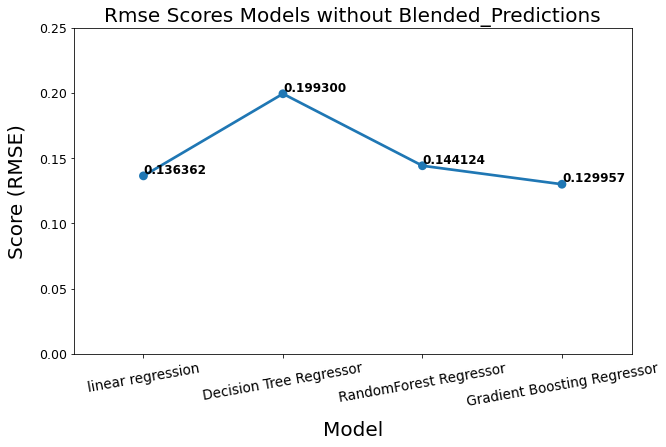

In [151]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.pointplot(x=list(rmse_scores.keys()), \
                   y=[score for score, _ in rmse_scores.values()], markers=['o'], linestyles=['-'], ax=ax)

for i, score in enumerate(rmse_scores.values()):
  ax.text(i, score[0]+0.002, '{:.6f}'.format(score[0]), horizontalalignment ='left', size='large', color='black', weight='semibold')
  ax.set_ylabel('Score (RMSE)', size=20, labelpad=12.5)
  ax.set_xlabel('Model', size=20, labelpad=12.5)
  ax.tick_params (axis='x', labelsize=13.5, rotation=10)
  ax.tick_params (axis='y', labelsize=12.5)
  ax.set_ylim(0, 0.25)
  ax.set_title('Rmse Scores Models without Blended_Predictions', size=20)
fig.show()

In [160]:
lr_model_fit=lr_model.fit(X, y)
tree_model_fit=tree_model.fit(X, y)
rf_model_fit=rf_model.fit(X, y)
gbr_model_fit=gbr_model.fit(X, y)

In [184]:
def blended_learning_predictions(X) :   # 각 알고리즘마다 가중치 적용
  blended_score = (0.3 * lr_model_fit.predict(X))+\
                  (0.1 * tree_model_fit.predict(X))+\
                  (0.3 * gbr_model_fit.predict(X))+\
                  (0.3 * rf_model_fit.predict(X))
  return blended_score

In [185]:
blended_score=rmsle(y, blended_learning_predictions(X))
rmse_scores['blended']=(blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.06258009975397949


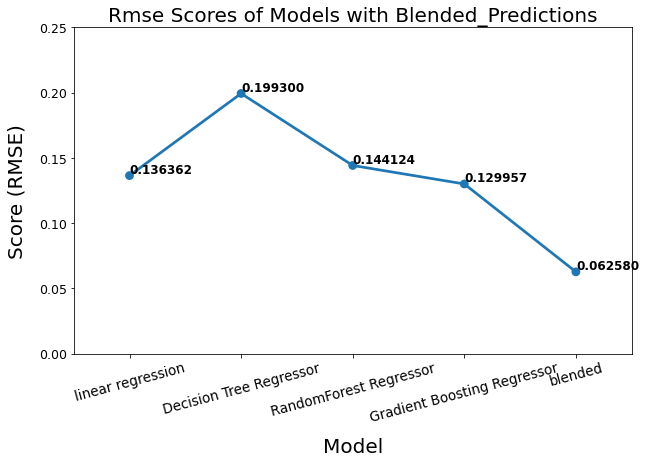

In [186]:
fig, ax=plt.subplots(figsize=(10, 6))
ax=sns.pointplot(x=list(rmse_scores.keys()), y=[score for score, _ in rmse_scores.values()], markers=['o'], linestyles=['-'], ax=ax)
for i, score in enumerate(rmse_scores.values()):
  ax.text(i, score[0]+0.002, '{:.6f}'.format(score[0]), horizontalalignment = 'left', size='large', color='black', weight='semibold')
  ax.set_ylabel('Score (RMSE)', size=20, labelpad=12.5)
  ax.set_xlabel('Model', size=20, labelpad=12.5)
  ax.tick_params (axis='x', labelsize=13.5, rotation=15)
  ax.tick_params (axis='y', labelsize=12.5)
  ax.set_ylim(0, 0.25)
  ax.set_title('Rmse Scores of Models with Blended_Predictions', size=20)
fig.show()

In [187]:
# 캐글에 제출하기

submission.iloc[:, 1]=np.floor(np.expm1(blended_learning_predictions(X_test)))
submission.to_csv("The_second_regression.csv", index=False)
